In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np

In [13]:
def load_mnist(batch_size=64):
    transform = transforms.Compose([transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))])
    
    train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)
    
    return train_loader, test_loader

In [14]:
class CNN_Net(nn.Module):
    def __init__(self,filters=(64,32) ,kernel_size=3,batch_norm=False,dropout=False):
        super().__init__()
        layers = []
        in_ch = 1
        
        for f in filters:
            layers.append(nn.Conv2d(in_ch, f, kernel_size, padding=1))
            if batch_norm:
                layers.append(nn.BatchNorm2d(f))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(2))
            if dropout:
                layers.append(nn.Dropout(0.2))
            in_ch = f
        
        self.conv = nn.Sequential(*layers)
        
        with torch.no_grad():
            dummy = torch.zeros(1, 1, 28, 28)
            dummy_out = self.conv(dummy)
            self.flatten_size = dummy_out.view(1, -1).shape[1]
        
        self.fc = nn.Linear(self.flatten_size,10)
        
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [15]:
def train_model(model,train_loader,test_loader,optimizer,dev,epoch=5,lr=0.001):
    # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    optimizer = optimizer(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    plotter = LivePlot()
    
    train_losses , test_losses = [], []
    train_acc, test_acc = [], []
    
    for e in range(epoch):
        model.train()
        correct , total  = 0,0
        running_loss = 0.0
        
        for batch_idx , (images , labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            acc = correct / total
            plotter.update(loss.item(),acc)
            
            if batch_idx % 200 == 0:
                clear_output(wait=True)
                print(f"Epoch {e+1}/{epoch}, Step {batch_idx}, Loss: {loss.item():.4f}, Acc: {acc:.4f}")
                show_predictions(images, labels, outputs)
        
        train_losses.append(running_loss/len(train_loader))
        train_acc.append(correct/total)
        
        model.eval()
        correct, total = 0,0
        running_loss = 0.0
        
        with torch.no_grad():
            for images , labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
            
        test_losses.append(running_loss/len(test_loader))
        test_acc.append(correct/total)
            
        print(f"Epoch {e+1}/{epoch}:")
        print(f"  Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}")
        print(f"  Test Loss:  {test_losses[-1]:.4f}, Test Acc:  {test_acc[-1]:.4f}")
   
    plt.ioff()
    plt.show()
            
    return train_losses, test_losses, train_acc, test_acc
    

In [16]:
def show_predictions(images, labels, outputs):
    preds = outputs.argmax(dim=1)
    images = images.cpu()
    labels = labels.cpu()
    preds = preds.cpu()

    plt.figure(figsize=(12,4))
    for i in range(min(8, len(images))):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        if preds[i] == labels[i]:
            color = 'green'
        else:
            color = 'red'
        plt.title(f"P:{preds[i].item()}\nT:{labels[i].item()}", color=color)
        plt.axis('off')
    plt.show()

In [17]:
class LivePlot:
    def __init__(self):
        self.losses = []
        self.accs = []
        plt.ion()
        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 4))

    def update(self, loss, acc):
        self.losses.append(loss)
        self.accs.append(acc)

        self.ax[0].clear()
        self.ax[1].clear()

        self.ax[0].plot(self.losses)
        self.ax[0].set_title("Training Loss")
        self.ax[0].set_xlabel("Steps")
        self.ax[0].set_ylabel("Loss")

        self.ax[1].plot(self.accs)
        self.ax[1].set_title("Training Accuracy")
        self.ax[1].set_xlabel("Steps")
        self.ax[1].set_ylabel("Accuracy")

        plt.pause(0.01)


In [18]:
def plot_training(train_losses, test_losses, train_accs, test_accs, title="Training Curves"):
    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, test_accs, label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    plt.suptitle(title)
    plt.show()


In [19]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

def visualize_activation_maps(net, test_loader, device=None, num_images=1, num_maps=8, cmap='magma'):
    """
    Visualize activation maps after ReLU layers for test images.
    
    net: trained CNN model
    test_loader: DataLoader for test dataset
    device: 'cpu', 'mps', or 'cuda'
    num_images: how many images from the test set to visualize
    num_maps: number of channels to show per layer
    cmap: colormap for visualization
    """
    device = device or torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    net = net.to(device)
    net.eval()
    
    data_iter = iter(test_loader)
    
    for img_idx in range(num_images):
        sample_images, sample_labels = next(data_iter)
        input_image = sample_images[0:1].to(device)
        true_label = sample_labels[0].item()
        
        # Prediction
        with torch.no_grad():
            prediction = torch.argmax(net(input_image), dim=1).item()
        
        # Show original image
        plt.figure(figsize=(3,3))
        plt.imshow(sample_images[0].squeeze(), cmap='gray')
        plt.title(f'Input: {true_label}, Predicted: {prediction}', color='green' if prediction==true_label else 'red')
        plt.axis('off')
        plt.show()
        
        # Collect activations after ReLU
        activations = []
        current = input_image.clone()
        block_idx = 0
        for layer in net.features if hasattr(net, 'features') else net.conv:
            current = layer(current)
            if isinstance(layer, nn.ReLU):
                block_idx += 1
                activations.append((block_idx, current.detach().cpu()))
        
        # Plot activation maps
        for block_id, activation_tensor in activations:
            n_maps = min(num_maps, activation_tensor.shape[1])
            cols = 4
            rows = math.ceil(n_maps / cols)
            fig, axes = plt.subplots(rows, cols, figsize=(cols*2.3, rows*2.3))
            fig.suptitle(f'Block {block_id} activation maps (showing {n_maps})', fontsize=14, y=1.02)
            axes = np.array(axes).reshape(rows, cols)
            
            act_min = activation_tensor.min().item()
            act_max = activation_tensor.max().item()
            
            for idx, ax in enumerate(axes.flat):
                if idx < n_maps:
                    ax.imshow(activation_tensor[0, idx], cmap=cmap, vmin=act_min, vmax=act_max)
                    ax.set_title(f'Channel {idx}', fontsize=8)
                    ax.axis('off')
                else:
                    ax.axis('off')
            plt.tight_layout()
            plt.show()


In [20]:
def visualize_feature_maps_test(model, test_loader, device=None, num_images=3, layer_indices=None):
    """
    Visualize feature maps for a few test images.
    
    model: trained CNN model
    test_loader: DataLoader for test dataset
    device: 'mps', 'cuda', or 'cpu'
    num_images: how many test images to visualize
    layer_indices: list of conv layer indices to show; None = all conv layers
    """
    import matplotlib.pyplot as plt
    
    device = device or torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Get some test images
    data_iter = iter(test_loader)
    for _ in range(num_images):
        images, labels = next(data_iter)
        image = images[0].to(device)  # first image in batch
        label = labels[0].item()
        
        # Get model prediction
        output = model(image.unsqueeze(0))  # add batch dimension
        pred = output.argmax(1).item()
        
        # Show original image and prediction
        plt.figure(figsize=(3,3))
        plt.imshow(images[0].squeeze(), cmap='gray')
        plt.title(f"True: {label}, Predicted: {pred}", color='green' if pred==label else 'red')
        plt.axis('off')
        plt.show()
        
        # Visualize feature maps
        x = image.unsqueeze(0)
        feature_maps = []
        for i, layer in enumerate(model.conv):
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                feature_maps.append((i, x.cpu().detach()))
        
        # Filter only selected layers
        if layer_indices is not None:
            feature_maps = [fm for fm in feature_maps if fm[0] in layer_indices]
        
        # Plot feature maps
        for idx, fmap in feature_maps:
            fmap = fmap.squeeze(0)  # remove batch
            n_filters = fmap.shape[0]
            cols = 8
            rows = (n_filters // cols) + 1
            plt.figure(figsize=(12, 3*rows))
            plt.suptitle(f"Feature Maps of Conv Layer {idx}")
            for i in range(n_filters):
                plt.subplot(rows, cols, i+1)
                plt.imshow(fmap[i], cmap='gray')
                plt.axis('off')
            plt.show()


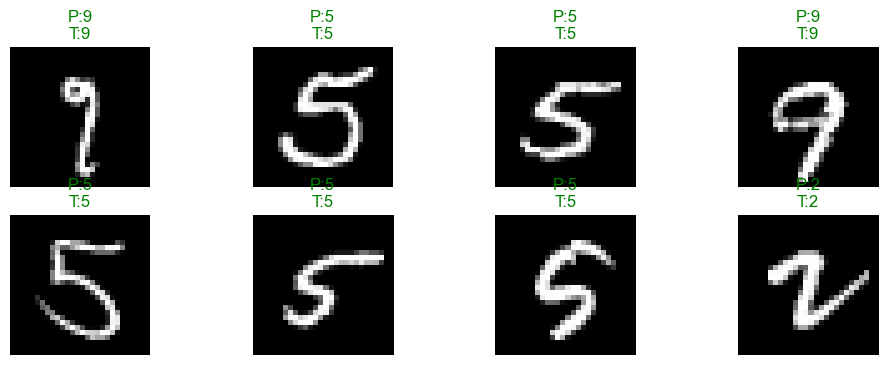

Epoch 7/7:
  Train Loss: 0.0203, Train Acc: 0.9934
  Test Loss:  0.0179, Test Acc:  0.9949


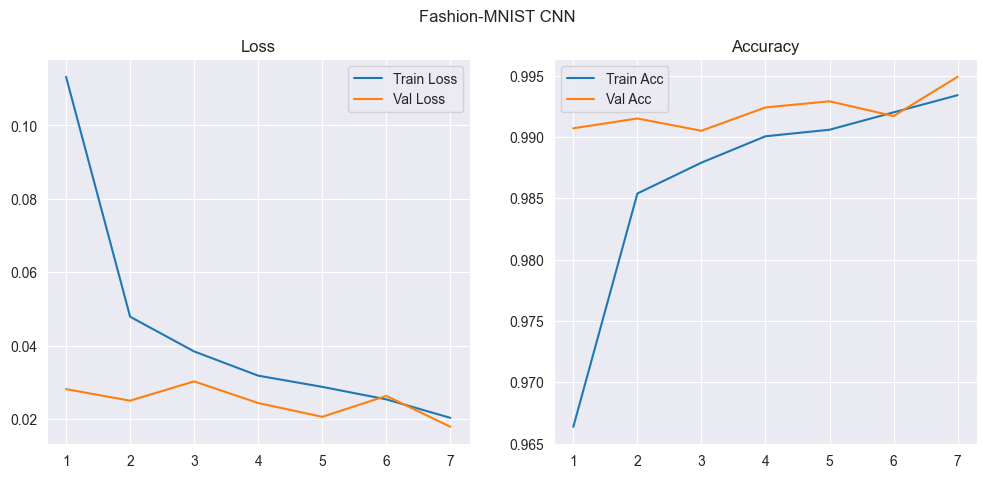

In [21]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)

train_f, test_f = load_mnist()

best_cnn = CNN_Net(filters=[32,64,128],kernel_size=5,batch_norm=True, dropout=True)
tl, vl, ta, va = train_model(best_cnn, train_f, test_f,optim.Adam,device,epoch=7,lr=0.003)

plot_training(tl, vl, ta, va, title="Fashion-MNIST CNN")


In [22]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Visualize 3 test images and their feature maps
# visualize_feature_maps_test(best_cnn, test_f, device=device, num_images=3)


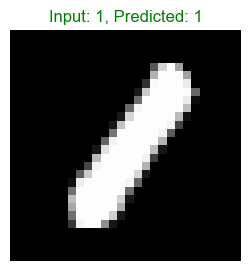

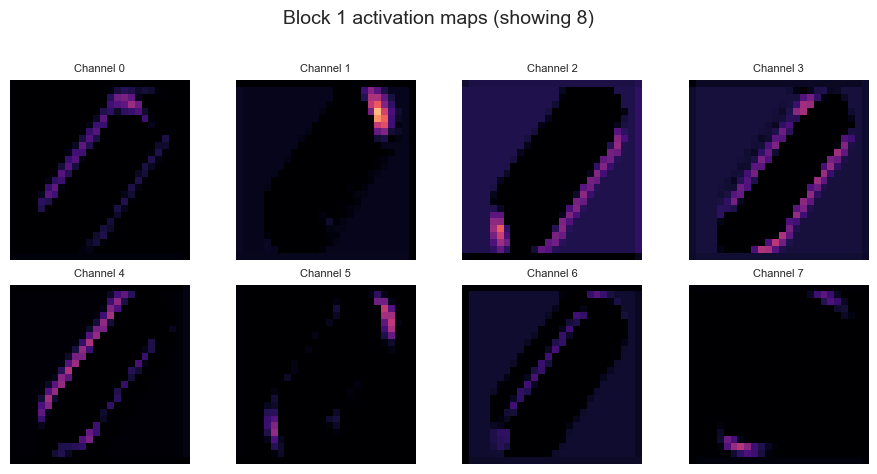

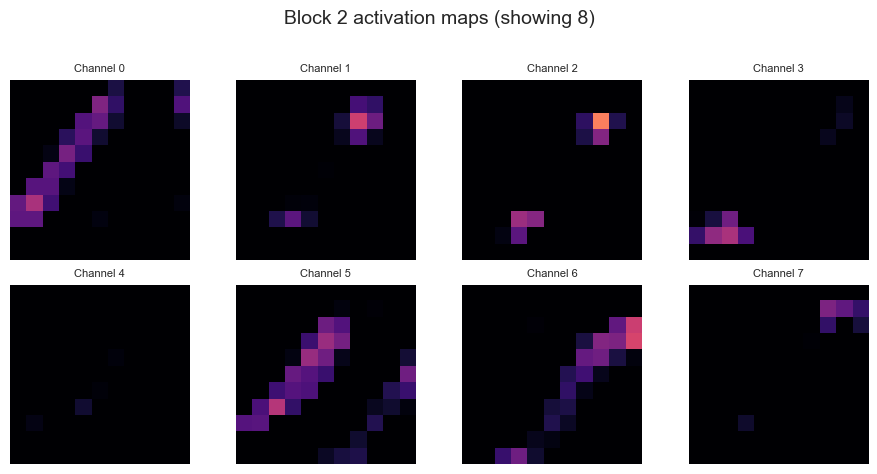

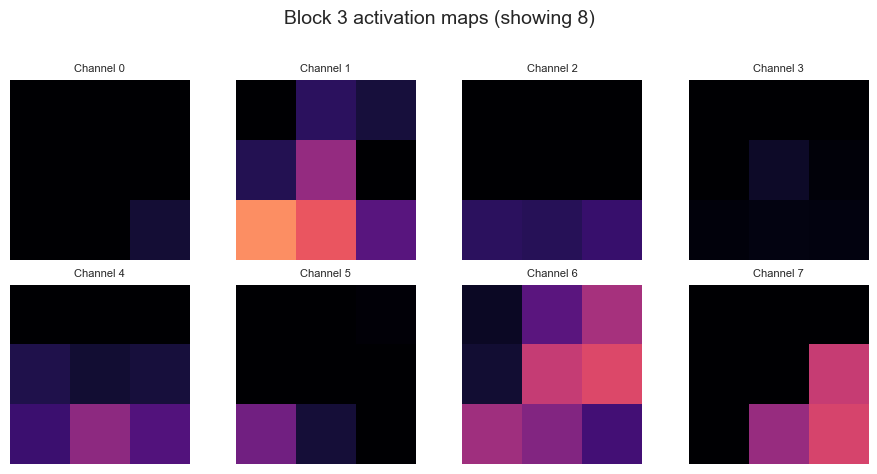

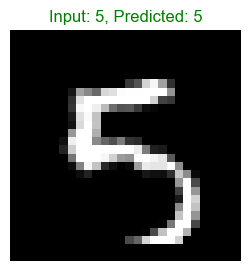

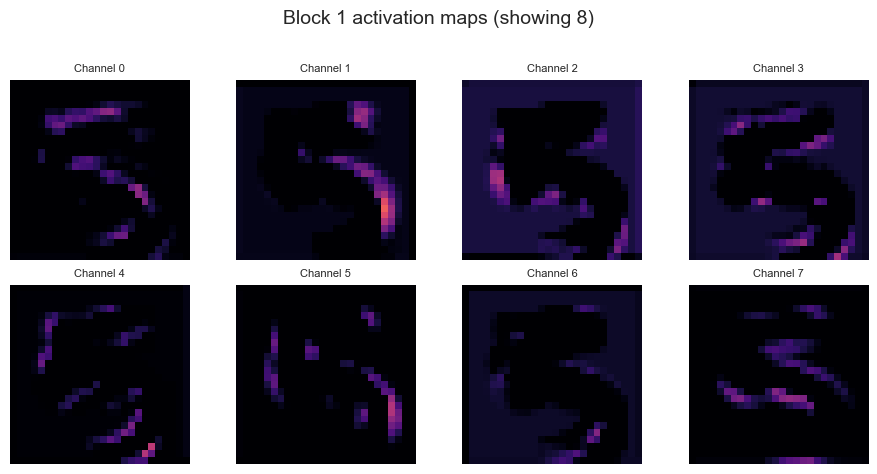

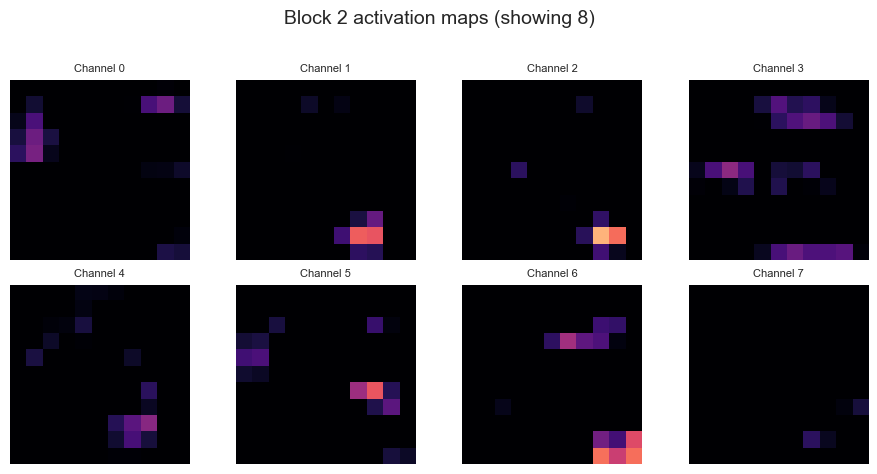

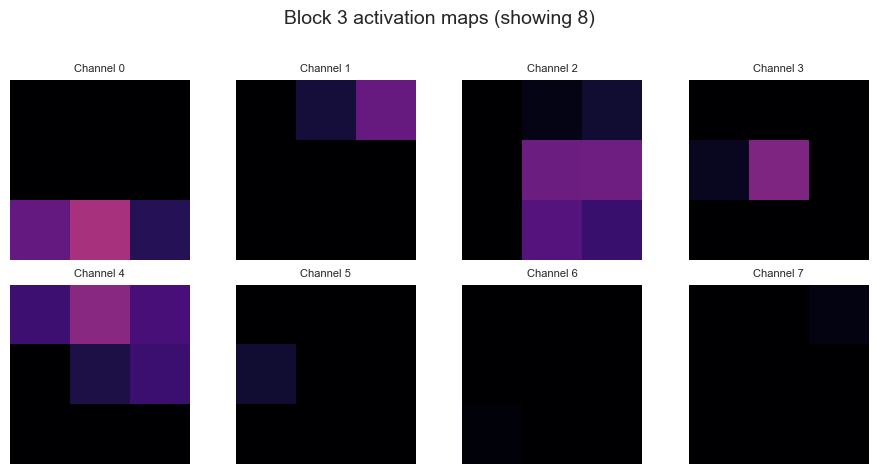

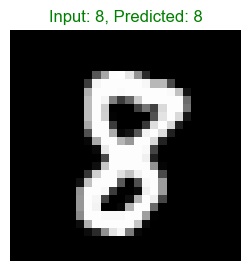

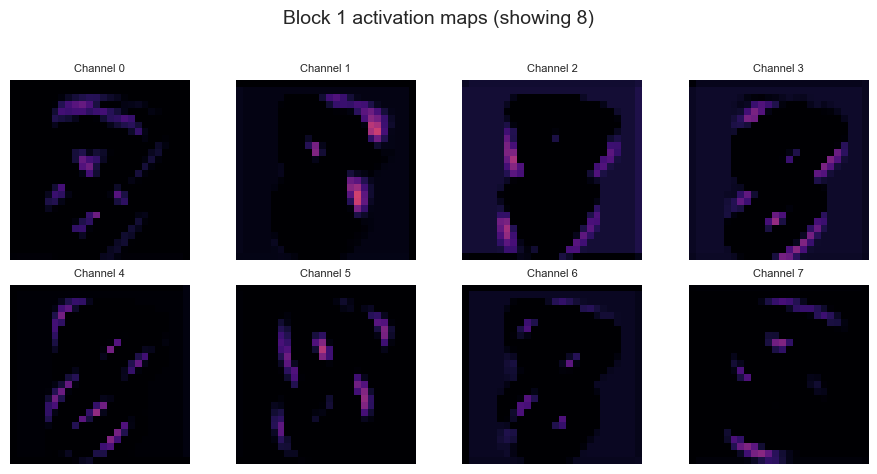

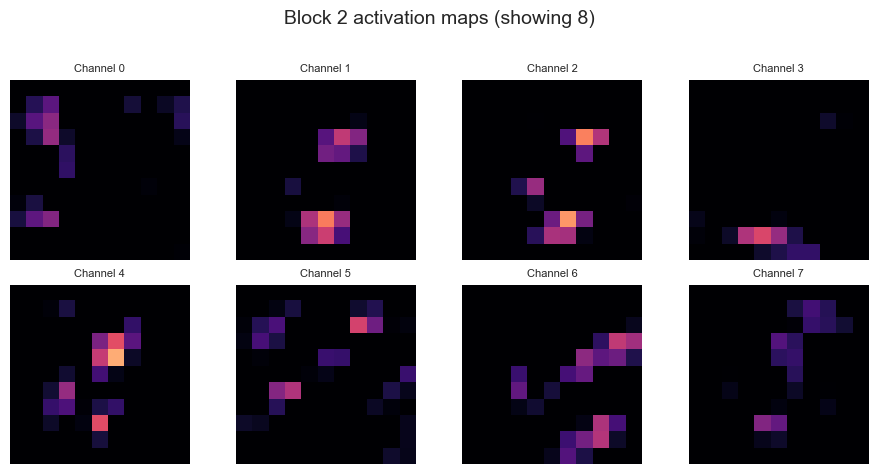

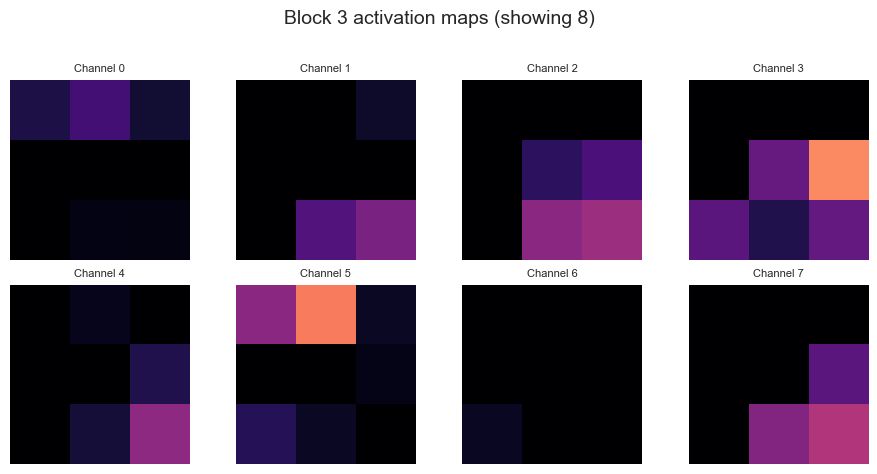

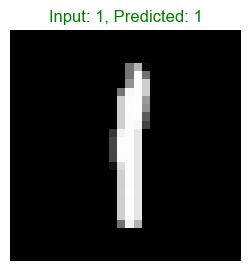

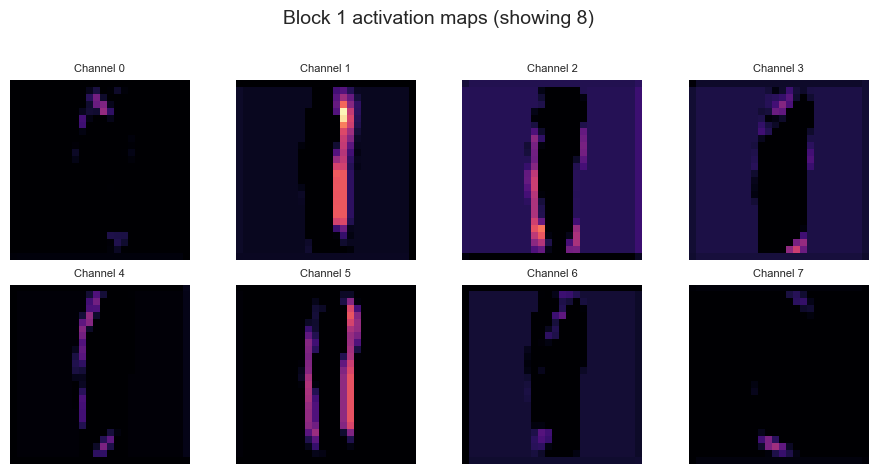

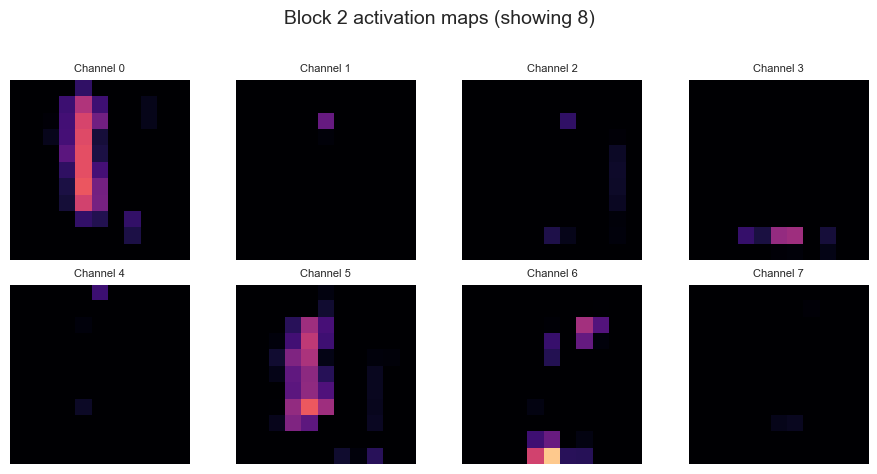

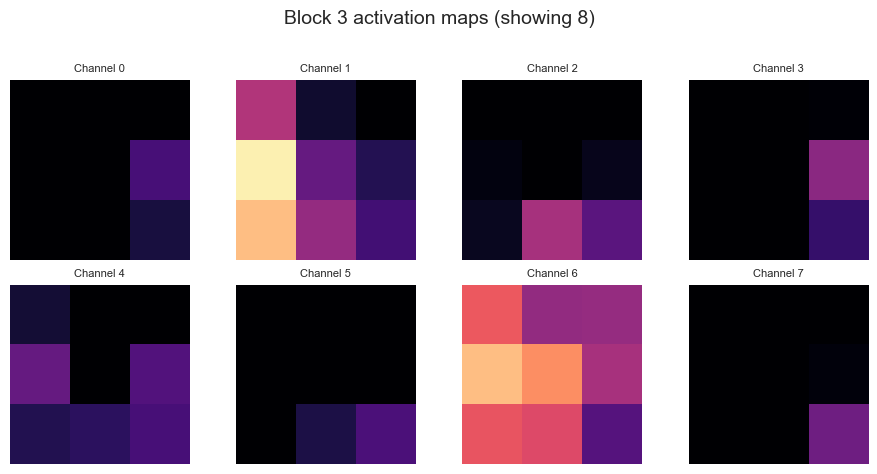

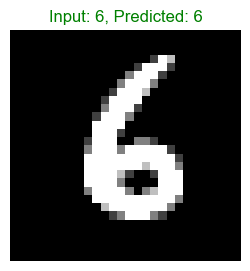

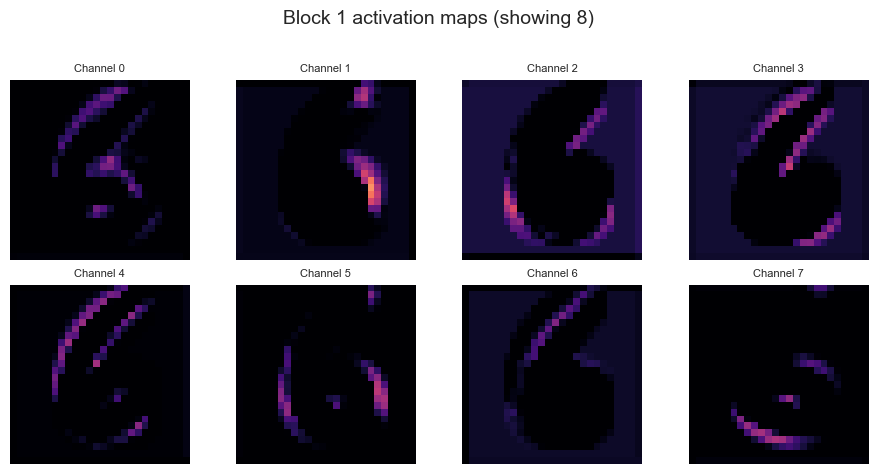

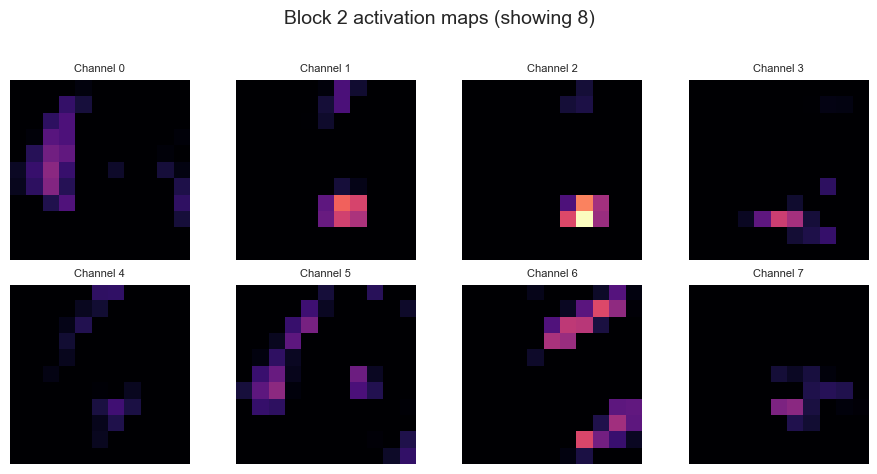

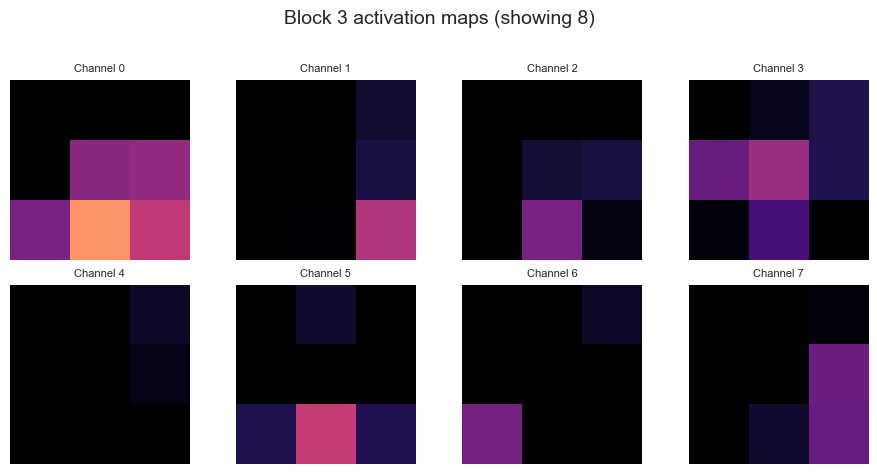

In [23]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

visualize_activation_maps(best_cnn, test_f, device=device, num_images=5, num_maps=8)
